## Why waste sorting?

Recycling contamination occurs when waste is incorrectly disposed of - like recycling a pizza box with oil on it (compost). Or when waste is correctly disposed of but incorrectly prepared - like recycling unrinsed jam jars.

Contamination is a [huge problem](http://mediaroom.wm.com/the-battle-against-recycling-contamination-is-everyones-battle/) in the recycling industry that can be mitigated with automated waste sorting. Just for kicks, I thought I'd try my hand at prototyping an image classifier to classify trash and recyclables - this classifier could have applications in an optical sorting system.

## Building an image classifier

In this project, I'll train a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). I used an image dataset collected manually by Gary Thung and Mindy Yang. Download their dataset [here](https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip) to follow along, then move it to the same directory as this notebook. (Note: you'll want to use a GPU to speed up training.)

#### My modeling pipeline:

1. Download and extract the images
2. Organize the images into different folders
3. Train model
4. Make and evaluate test predictions
5. Next steps

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [3]:
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import random
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [4]:
os.chdir('C:\\Users\\cwihe\\Documents\\Waste Sorter Project')
os.getcwd()

'C:\\Users\\cwihe\\Documents\\Waste Sorter Project'

In [23]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [24]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## 2. Organize images into different folders

Now that we've extracted the data, I'm going to split images up into train, validation, and test image folders with a 50-25-25 split. First, I'll define some functions that will help me quickly build it. If you're not interested in building the data set, you can just run this ignore it.

In [25]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, I'm going to create a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

Again, this is just housekeeping to organize my files.

In [5]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

NameError: name 'split_indices' is not defined

I set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [6]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

Path('C:/Users/cwihe/Documents/Waste Sorter Project/data')

In [7]:
tfms = aug_transforms(do_flip=True,flip_vert=True)
data = ImageDataLoaders.from_folder(path,train = 'train', valid = 'valid', bs=16, batch_tfms = tfms)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

You can use get_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [ ]:
data.valid

In [ ]:
print(data.vocab)

Here's an example of what the data looks like:

In [ ]:
data.valid.show_batch(max_n = 15)

## 3. Model training

In [8]:
learn = vision_learner(data,models.resnet34,metrics=error_rate)

C:\Users\cwihe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cwihe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### What is resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

Since they're capable of describing more complexity, deep neural networks should theoretically perform better than shallow networks on training data. In reality, though, deep neural networks tend to perform empirically worse than shallow ones. 

Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals). 

When adjustments are needed, shortcut connections apply the identity function to pass information to subsequent layers. This shortens the neural network when possible and allows resnets to have deep architectures and behave more like shallow neural networks. The 34 in resnet34 just refers to the number of layers.

Anand Saha gives a great more in-depth explanation [here](http://teleported.in/posts/decoding-resnet-architecture/).

In [ ]:
learn.model

### Finding a learning rate

I'm going to find a learning rate for gradient descent to make sure that my neural network converges reasonably quickly without missing the optimal error. For a refresher on the learning rate, check out Jeremy Jordan's [post](https://www.jeremyjordan.me/nn-learning-rate/) on choosing a learning rate. 

SuggestedLRs(valley=0.0022908677347004414)

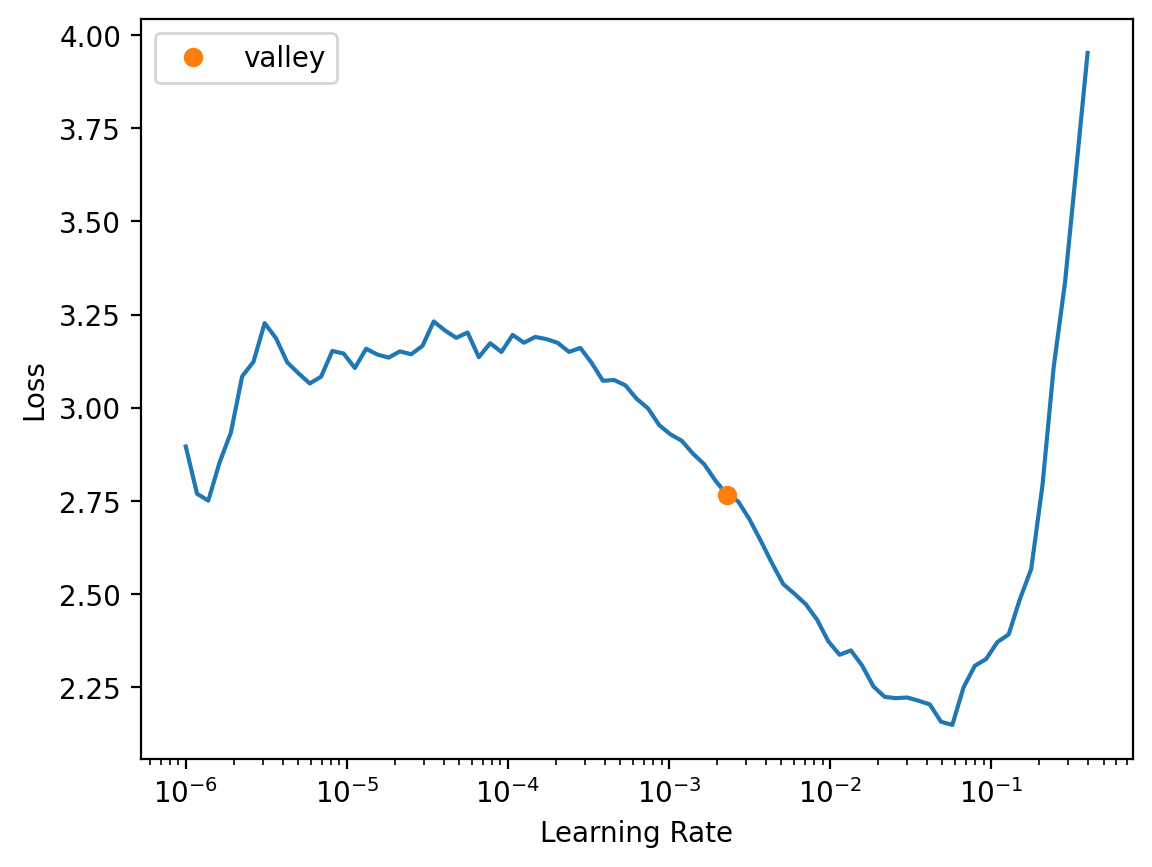

In [9]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [10]:
learn.fit_one_cycle(6, lr_max = 0.0022908677347004414)

epoch,train_loss,valid_loss,error_rate,time
0,1.549820,0.666813,0.215873,08:01
1,1.022567,0.653291,0.195238,07:59
2,0.834959,0.413764,0.139683,08:01
3,0.596133,0.380806,0.119048,08:30
4,0.464516,0.347672,0.109524,08:38
5,0.382384,0.340880,0.111111,08:29


I ran my model for 20 epochs. What's cool about this fitting method is that the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum. At 8.6%, the validation error looks super good... let's see how it performs on the test data though. 

First, we can take a look at which images were most incorrectly classified.

### VIsualizing most incorrect images

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

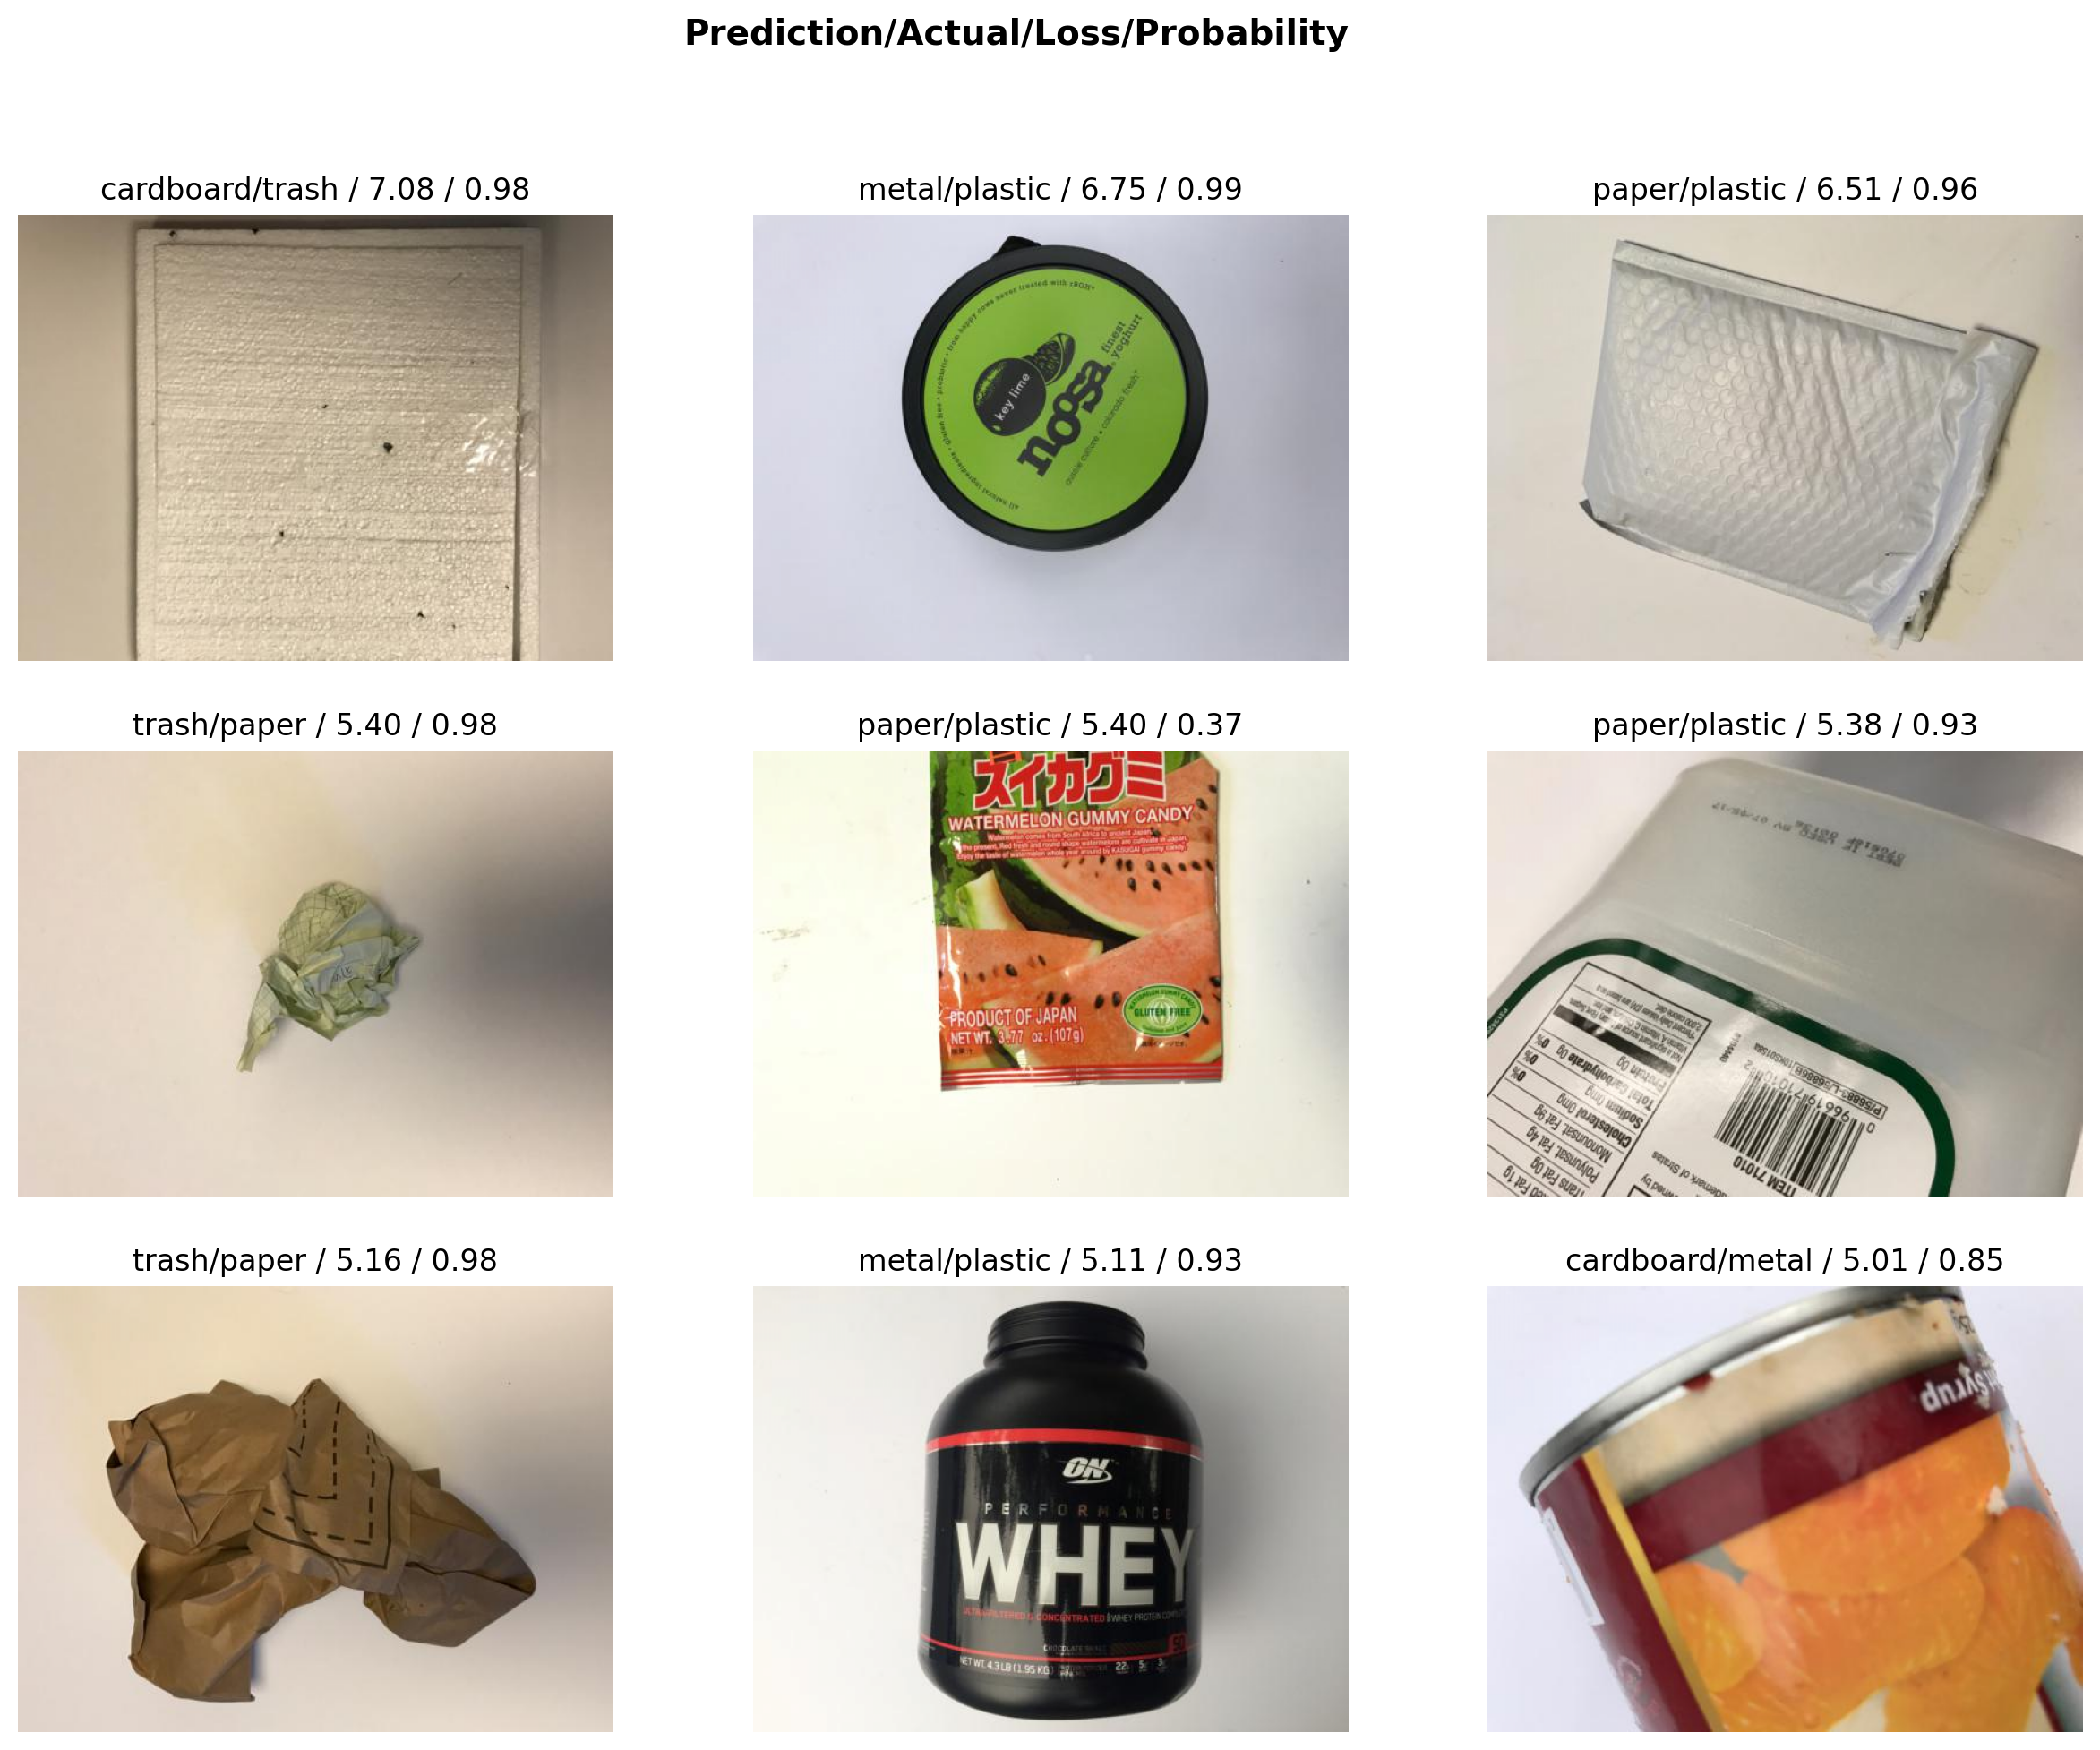

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

The images here that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

Interpretation.plot_top_losses(k: 'int | MutableSequence', largest: 'bool' = True, **kwargs)
Show `k` largest(/smallest) preds and losses. Implementation based on type dispatch

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


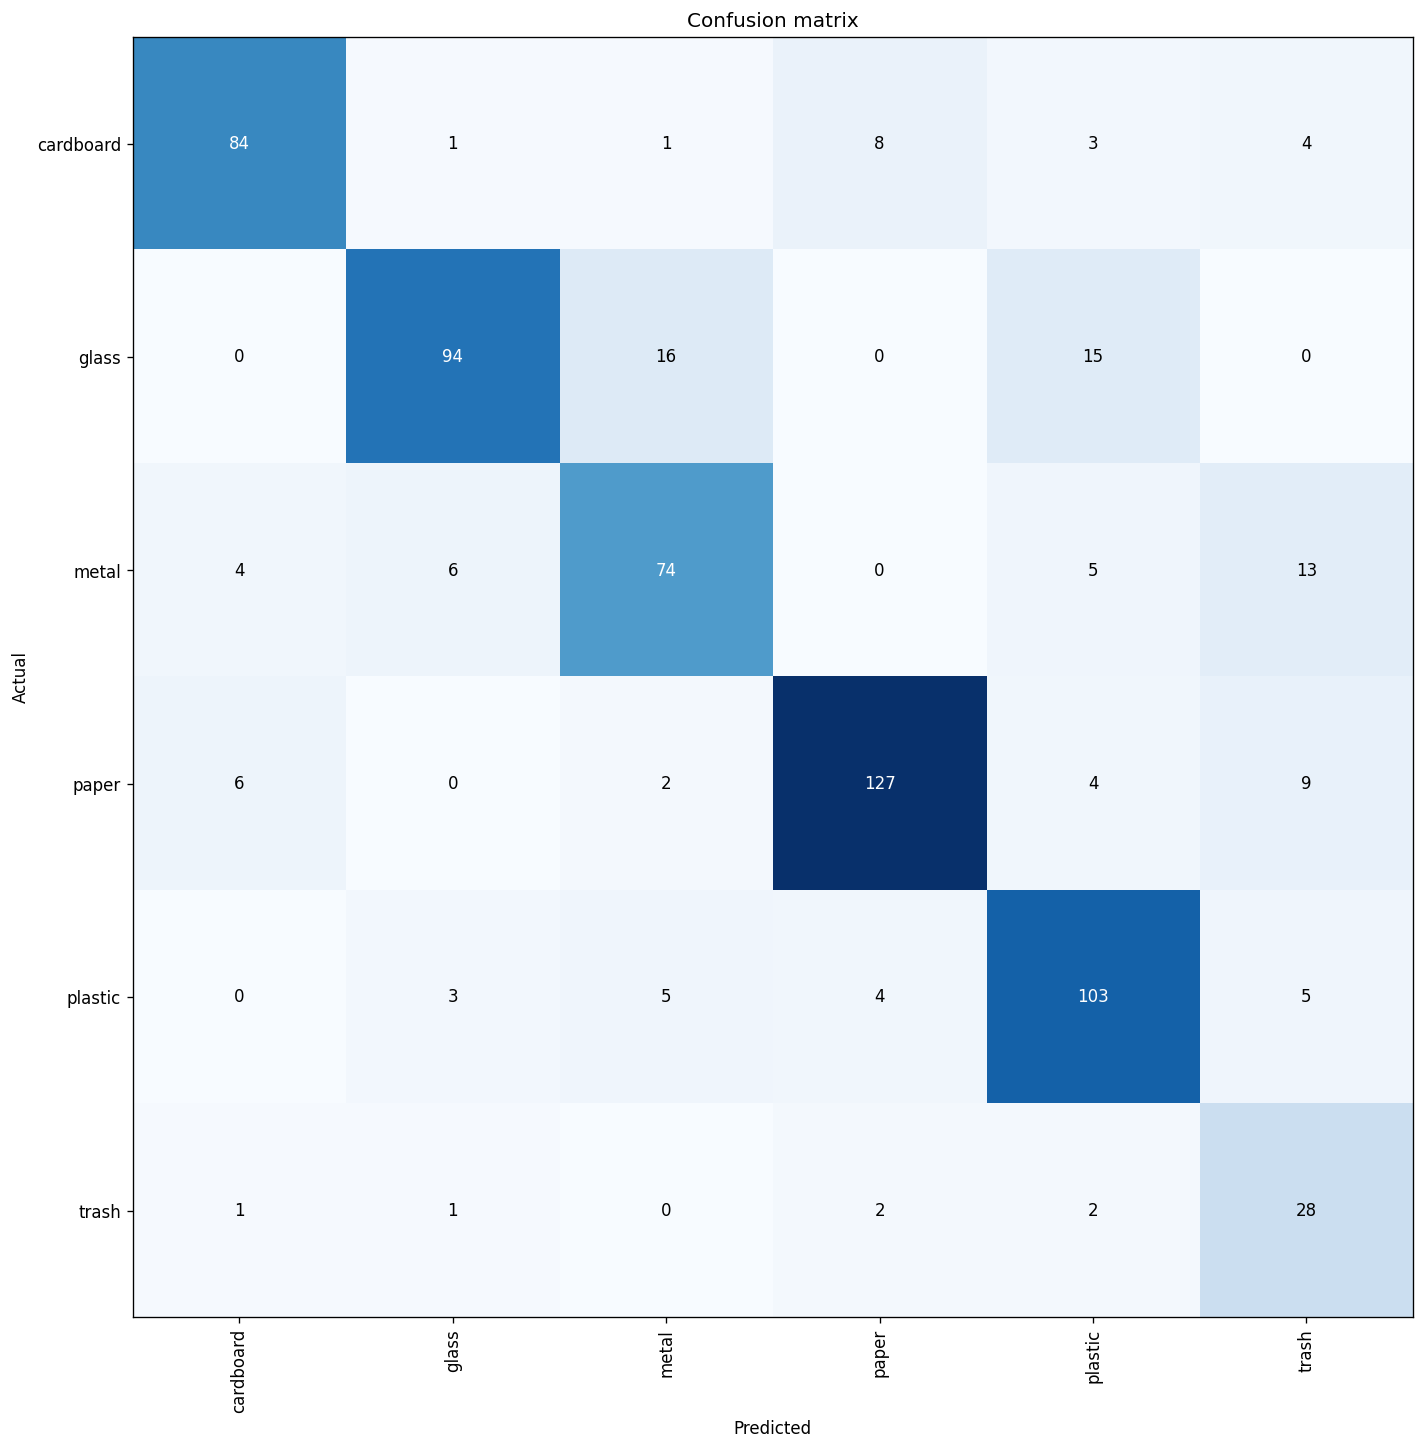

In [30]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [31]:
interp.most_confused(min_val=2)

[('glass', 'metal', 16),
 ('glass', 'plastic', 15),
 ('metal', 'trash', 13),
 ('paper', 'trash', 9),
 ('cardboard', 'paper', 8),
 ('metal', 'glass', 6),
 ('paper', 'cardboard', 6),
 ('metal', 'plastic', 5),
 ('plastic', 'metal', 5),
 ('plastic', 'trash', 5),
 ('cardboard', 'trash', 4),
 ('metal', 'cardboard', 4),
 ('paper', 'plastic', 4),
 ('plastic', 'paper', 4),
 ('cardboard', 'plastic', 3),
 ('plastic', 'glass', 3),
 ('paper', 'metal', 2),
 ('trash', 'paper', 2),
 ('trash', 'plastic', 2)]

## 4. Make new predictions on test data

To see how this mode really performs, we need to make predictions on test data. First, I'll make predictions on the test data using the learner.get_preds() method. 

**Note:** learner.predict() only predicts on a single image, while learner.get_preds() predicts on a set of images. I highly recommend reading the [documentation](https://docs.fast.ai/basic_train.html#Learner.get_preds) to learn more about predict() and get_preds().

In [32]:
tpath = Path(os.getcwd())/"data/test"
test_files = [fn for fn in sorted((tpath).glob('**/*')) if fn.is_file()]
test_files

[Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard500.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard501.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard502.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard503.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard504.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard505.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass500.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass501.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass502.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass503.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass504.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/metal500.bmp'),
 Path('C:/Users/cwihe/Docume

In [33]:
test_dl = learn.dls.test_dl(test_items=test_files, after_item = [ToTensor(), Resize((200, 150), method='squish')])

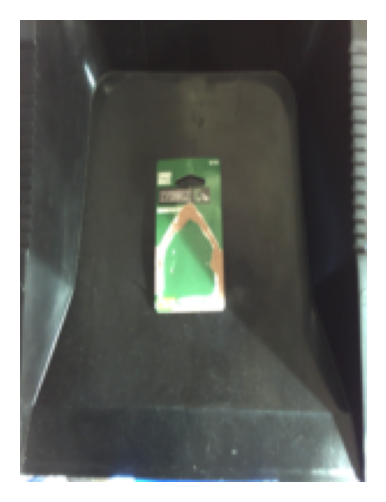

In [34]:
test_dl.show_batch(max_n = 1)

In [35]:
preds = learn.get_preds(dl = test_dl)

The ds_type argument in get_preds(ds_type) takes a [DataSet](https://docs.fast.ai/basic_data.html#DatasetType) argument. Example values are DataSet.Train, DataSet.Valid, and DataSet.Test. I mention this because I made the mistake of passing in actual data (learn.data.test_ds) which gave me the wrong output and took embarrassingly long to debug. 

Don't make this mistake! Don't pass in data -- pass in the dataset type!

In [36]:
print(preds[0].shape)
preds[0]

torch.Size([22, 6])


TensorBase([[3.0884e-01, 9.6770e-06, 4.2065e-03, 6.8585e-01, 1.7360e-04,
             9.2195e-04],
            [5.5156e-01, 4.2732e-06, 1.2602e-03, 4.4660e-01, 1.2559e-05,
             5.6612e-04],
            [2.6453e-02, 2.3266e-02, 1.5869e-02, 9.3421e-01, 1.5874e-04,
             4.7370e-05],
            [4.0150e-01, 6.2776e-07, 2.6511e-06, 5.9841e-01, 7.3519e-05,
             1.3786e-05],
            [1.0383e-01, 9.3482e-06, 2.1819e-02, 8.7376e-01, 4.1602e-05,
             5.4611e-04],
            [3.1952e-01, 1.7675e-03, 2.3062e-01, 4.4485e-01, 3.2329e-03,
             1.4689e-05],
            [1.7445e-02, 4.6843e-04, 1.1046e-02, 7.8937e-01, 1.8143e-01,
             2.3703e-04],
            [6.2960e-05, 7.0447e-01, 1.1102e-02, 2.8414e-01, 2.2862e-04,
             5.2418e-06],
            [8.0975e-05, 9.5212e-01, 3.6020e-02, 2.4936e-05, 1.1750e-02,
             5.1529e-06],
            [3.6622e-04, 9.2016e-01, 4.3468e-02, 2.2466e-02, 1.3500e-02,
             4.1718e-05],
          

These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [37]:
data.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [38]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [39]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.vocab[max_idx])

In [40]:
yhat

['paper',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'paper',
 'paper',
 'glass',
 'glass',
 'glass',
 'metal',
 'glass',
 'glass',
 'paper',
 'paper',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'trash']

In [41]:
test_dl.dataset.items

[Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard500.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard501.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard502.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard503.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard504.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/cardboard505.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass500.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass501.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass502.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass503.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/glass504.bmp'),
 Path('C:/Users/cwihe/Documents/Waste Sorter Project/data/test/metal500.bmp'),
 Path('C:/Users/cwihe/Docume

These are the predicted labels of all the images! Let's check if the first image is actually glass.

In [42]:
#interp1 = ClassificationInterpretation.from_learner(learn = learn, dl = test_dl)

In [43]:
#test_dl.show_results([0,1,2,3,4,5,6,7,8,9,10,11,12,13])

It is!

Next, I'll get the actual labels from the test dataset.

In [44]:
y = []

## convert POSIX paths to string first
for label_path in test_dl.dataset.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

AttributeError: 'NoneType' object has no attribute 'group'

A quick check.

In [ ]:
## predicted values
print(yhat[0:15])
## actual values
print(y[0:15])

In [ ]:
test_dl.show_batch(max_n = 20)

It looks the first five predictions match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

Let's try and make this matrix a little prettier.

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, I'm sure further investigation could help reduce these mistakes.

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

I ended up achieving an accuracy of 92.1% on the test data which is pretty great -- the original creators of the TrashNet dataset achieved [a test accuracy of 63%](http://cs229.stanford.edu/proj2016/poster/ThungYang-ClassificationOfTrashForRecyclabilityStatus-poster.pdf) with a support vector machine on a 70-30 test-train split (they trained a neural network as well for a test accuracy of 27%).

In [ ]:
## delete everything when you're done to save space
#shutil.rmtree("data")
#shutil.rmtree('dataset-resized')

In [91]:
def predictTrash():
    test_dl1 = learn.dls.test_dl(test_items="C:/Users/cwihe/Documents/Waste Sorter Project/Trash.jpg", after_item = [ToTensor(), Resize((200, 150), method='squish')])
    preds1 = learn.get_preds(dl = test_dl1)
    preds1[0]
    print(preds1[0])
    max_idxs = np.asarray(np.argmax(preds1[0],axis=1))
    x = data.vocab[max_idxs[0]]
    print(x)
    if x == "trash":
        return "1"
    elif x == "plastic":
        return "2"
    elif x == "paper" or x == "cardboard":
        return "3"
    else:
        return "4"
    
a = predictTrash()
print(a)

TensorBase([[1.3614e-04, 3.6280e-04, 3.4542e-06, 9.2565e-01, 7.3840e-02,
             6.9342e-06]])
paper
3


In [48]:
#with open('result.txt', 'w') as fp:
#   fp.write("hello")

In [90]:
# program to capture single image from webcam in python
  
# importing OpenCV library
from cv2 import *
import cv2
  
# initialize the camera
# If you have multiple camera connected with 
# current device, assign a value in cam_port 
# variable according to that
def takeImage():
    cam_port = 0
    cam = cv2.VideoCapture(cam_port)

    # reading the input using the camera
    result, image = cam.read()

    # If image will detected without any error, 
    # show result
    if result:

        # showing result, it take frame name and image 
        # output
        #cv2.imshow("Trash", image)

        # saving image in local storage
        cv2.imwrite("Trash.jpg", image)

        # If keyboard interrupt occurs, destroy image 
        # window
        #cv2.waitKey(0)
        #cv2.destroyWindow("Trash")

    # If captured image is corrupted, moving to else part
    else:
        print("No image detected. Please! try again")
takeImage()

In [16]:
import serial
import time
import random

a = serial.Serial(port="COM3", baudrate = 115200, timeout=.1)

def write_read(x):
    a.write(bytes(x, 'utf-8'))
    time.sleep(0.05)
    data = y
    return data

while True:
    y = a.readline()
    #print(y)
    #num = input("Enter a number: ")
    #y = ''
    #if(num == 'q'):
    #    a.close()
    #    break
    j = y.decode("utf-8") 
    if(j == "test"):
        print()
        print("Taking Picture...")
        #takeImage()
        s = predictTrash()
        value = write_read(s)
        print("sending num:", s)
    
    




Taking Picture...
No image detected. Please! try again


plastic
sending num: 2

Taking Picture...
No image detected. Please! try again


plastic
sending num: 2


KeyboardInterrupt: 

## 5. Next steps

If I had more time, I'd go back and reduce classification error for glass in particular. I'd also delete photos from the dataset that are overexposed, since those images are just bad data.

This was just a quick and dirty mini-project to show that it's pretty quick to train an image classification model, but it pretty amazing how quickly you can create a state-of-the-art model by using the fastai library. If you have an application you're interested in but don't think you have the machine learning chops, this should be encouraging for you.

Thanks to James Dellinger for this [blog post](https://blog.usejournal.com/if-i-can-you-can-and-you-should-a470d7aea89d) about classifying bluejays. For more information about recycling, check out this FiveThirtyEight [post](https://fivethirtyeight.com/features/the-era-of-easy-recycling-may-be-coming-to-an-end/).